# Graying the Black Box - Understanding DQNs

Implementation of Zahavy et al., 2016 (https://arxiv.org/abs/1602.02658)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from temporal_explanations_4_rl.dataset import (
    load_state_values,
    load_trajectories,
    load_discrete_actions,
)
from temporal_explanations_4_rl.graying_the_black_box import (
    SpatioTemporalKMeans,
)
from temporal_explanations_4_rl.plan import Plan
from temporal_explanations_4_rl.plot import (
    plot_skill_clusters,
    plot_skill_trajectory,
    plot_trajectory_skills,
    plot_embedding,
)
from temporal_explanations_4_rl.skill import skill_labels_to_trajectory_skills
from temporal_explanations_4_rl.utils import load_embedding

### Hyperparameter

In [3]:
agent_name = "dqn_adam_mse"
env_name = "Pong"
figsize = (13, 6)

In [4]:
dataset_path = f"../datasets/training/{agent_name}-{env_name}"

In [5]:
state_values = load_state_values(f"{dataset_path}/trajectories")
trajectories = load_trajectories(f"{dataset_path}/trajectories")
actions = load_discrete_actions(f"{dataset_path}/trajectories")

embedded_dataset = load_embedding(f"{dataset_path}/tsne-dense-50.npz")

## T-SNE embedding

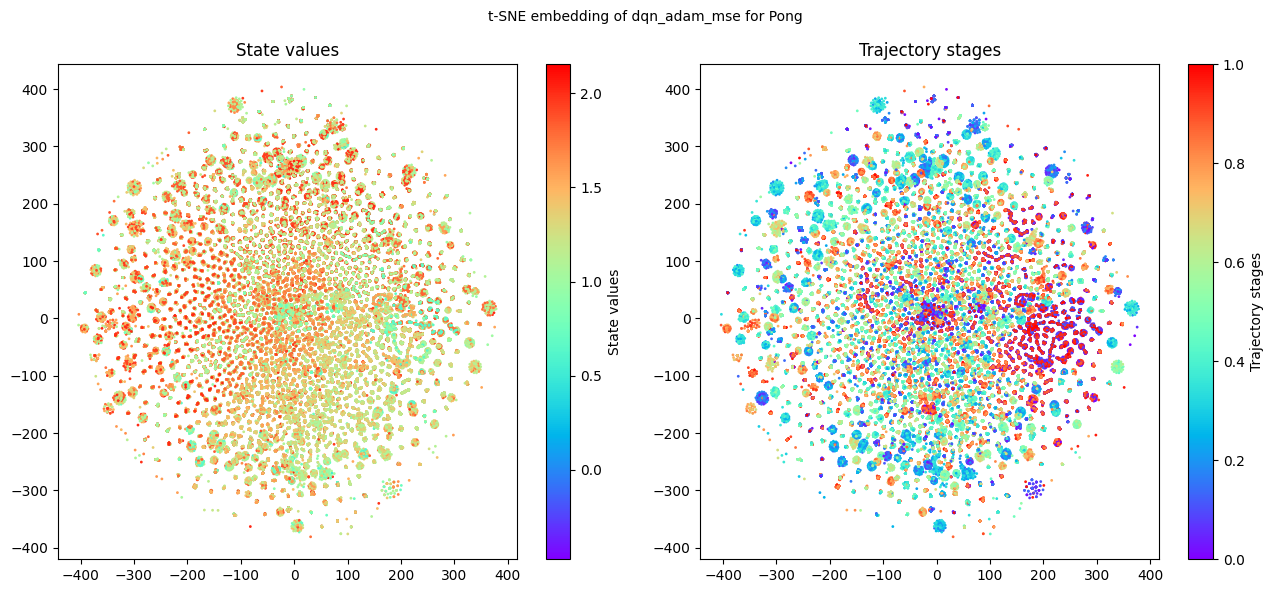

In [9]:
plot_embedding(
    embedded_dataset,
    state_values,
    trajectories,
    title=f"t-SNE embedding of {agent_name} for {env_name}",
    figsize=figsize,
)
plt.savefig(f"figs/graying-policy-visualisation.png")

## KMeans clustering

In [12]:
kmeans = SpatioTemporalKMeans(num_clusters=10, window_size=1)
kmeans.fit(embedded_dataset, state_values, trajectories)
skill_labels = kmeans.label(embedded_dataset, state_values, trajectories)

trajectory_skills = skill_labels_to_trajectory_skills(
    skill_labels, actions, trajectories
)
plan = Plan(trajectory_skills)


48it [00:02, 18.71it/s]


(<Figure size 1300x600 with 1 Axes>,
 <AxesSubplot:title={'center':'Clustered skills of dqn_adam_mse for Pong'}>)

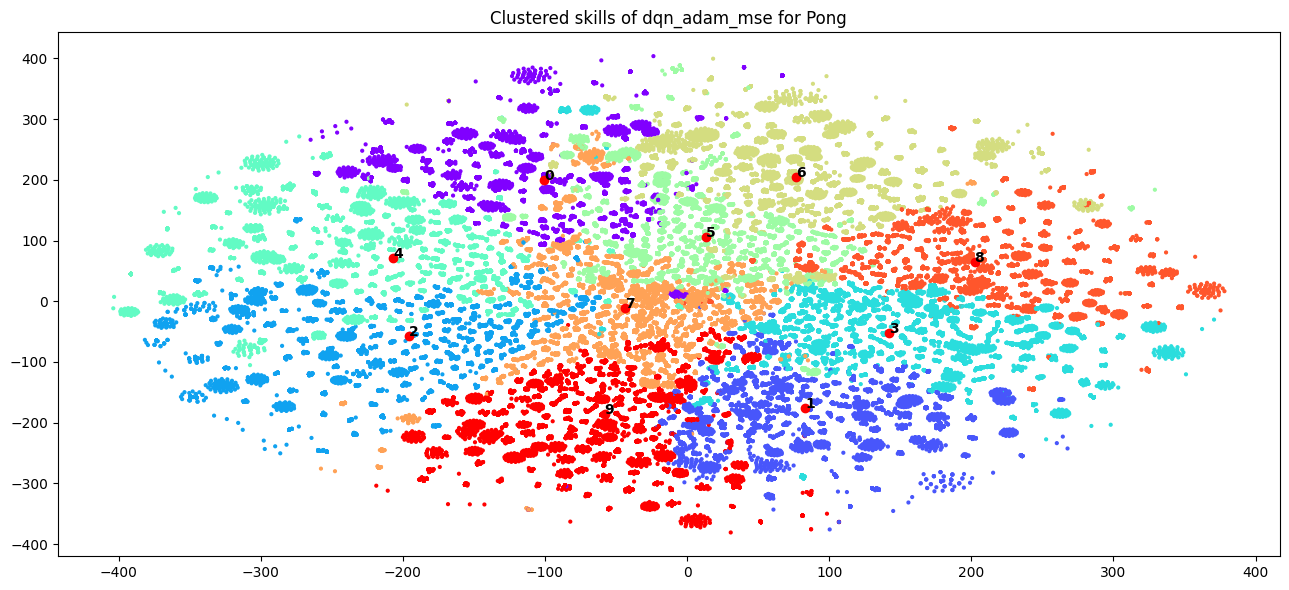

In [13]:
plot_skill_clusters(
    embedded_dataset,
    skill_labels,
    kmeans.cluster_centers,
    title=f"Clustered skills of {agent_name} for {env_name}",
    figsize=figsize,
)
plt.savefig("figs/graying-the-black-box-clusters.png")

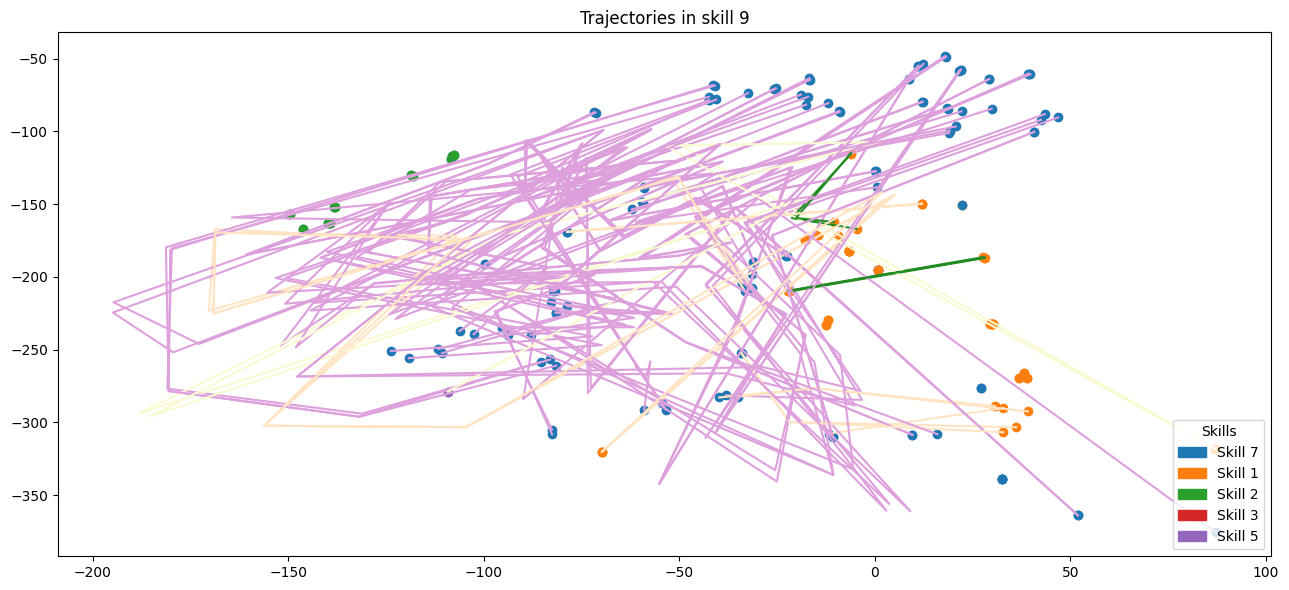

In [16]:
plot_skill_num = 9
skill_9_transitions = np.concatenate(plan.transitions[9])
plot_skill_trajectory(
    embedded_dataset,
    skill_9_transitions,
    plot_skill_num,
    title=f"Trajectories in skill {plot_skill_num}",
    figsize=figsize,
)
plt.savefig("figs/graying-the-black-box-skill-9-trajectories.png")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

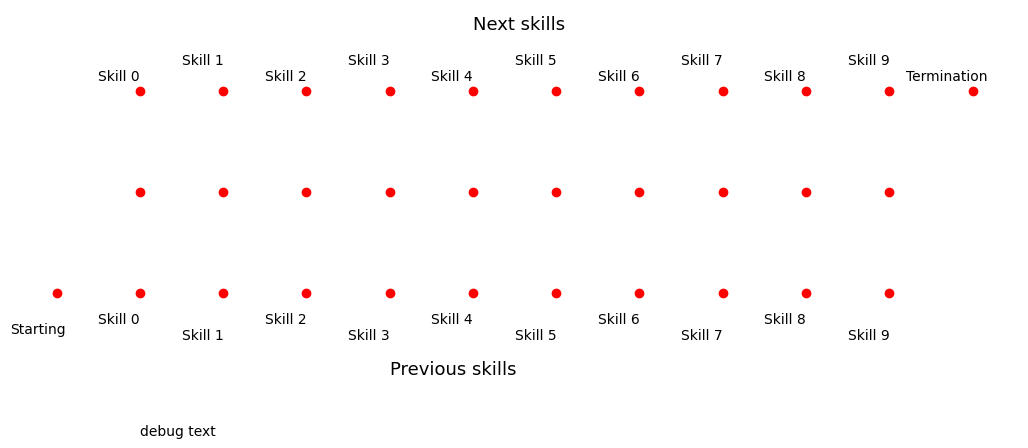

In [15]:
# plan.plot(figsize=(13, 5))

/home/mark/Documents/programming/baseline-temporal-explanations-expermential/baseline_temporal_explanations/plot.py:268: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


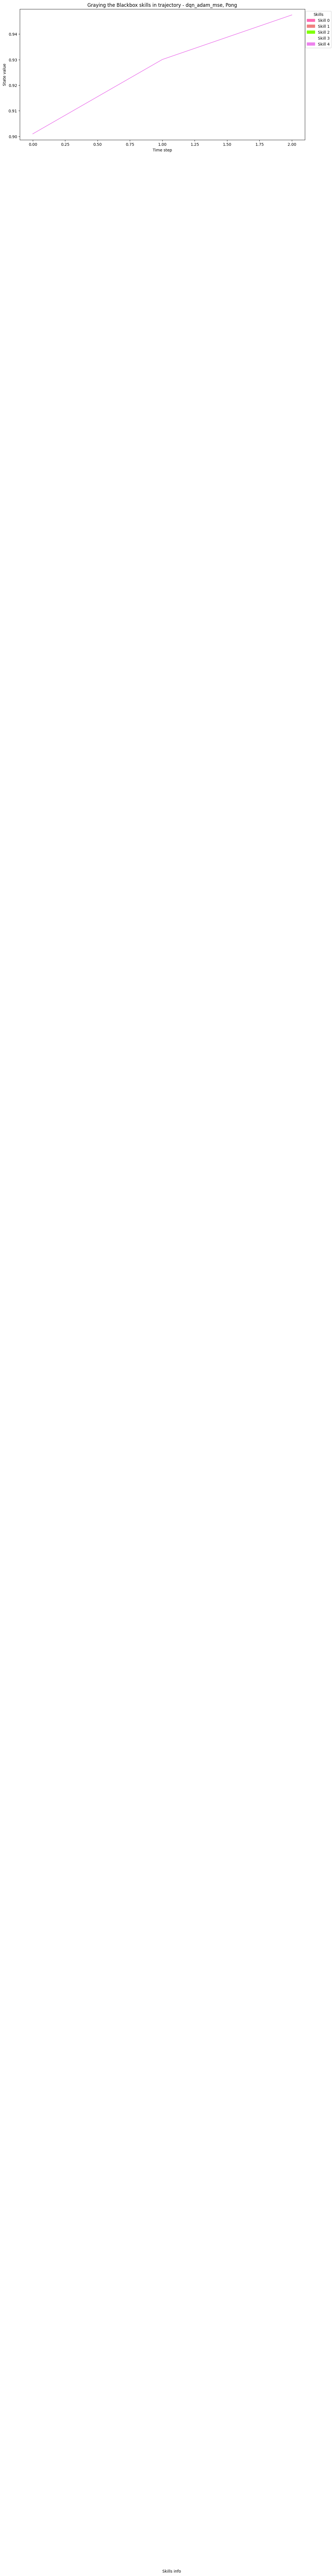

In [17]:
plot_trajectory_skills(
    trajectory_skills[0],
    state_values,
    title=f"Graying the Blackbox skills in trajectory - {agent_name}, {env_name}",
    figsize=figsize,
)
plt.savefig("figs/graying-the-black-box-trajectory-skills.png")

## Evaluation

In [ ]:
_, axs = plt.subplots(ncols=3, figsize=figsize)
axs[0].set_title("Skill Transition Entropy")
entropy = plan.entropy()
axs[0].imshow(entropy)

axs[1].set_title("Skill Length Distribution")
distribution = plan.transition_length_distribution()
axs[1].imshow(distribution)

axs[2].set_title("Skill Alignment")
axs[2].bar(plan.alignment())

## Grid search over hyperparameters

In [ ]:
with np.load(f"{dataset_path}/graying-the-black-box/results.npz") as file:
    num_clusters = file["num_clusters"]
    window_sizes = file["window_sizes"]

    entropy = file["entropy"]
    distribution = file["distribution"]
    alignment = file["alignment"]

f"Num clusters: {num_clusters}, window sizes: {window_sizes}"

In [ ]:
_, axs = plt.subplots(ncols=3, figsize=(12, 7))
axs[0].set_title("Plan Entropy")
axs[0].imshow(entropy)
axs[1].set_title("Skill length distribution")
axs[1].imshow(distribution)
axs[2].set_title("Skill Alignment")
axs[2].imshow(alignment)

In [ ]:
fig = plt.figure(figsize=(14, 8))

mesh_window_size, mesh_num_clusters = np.meshgrid(window_sizes, num_clusters)
for pos, (title, scores) in enumerate(
    zip(
        ["Skill Transition Entropy", "Skill Length Distribution", "Alignment"],
        [entropy, distribution, alignment],
    )
):
    ax = fig.add_subplot(pos, 2, 3, projection="3d")
    ax.set_title(title)
    ax.set_xlabel("Window size")
    ax.set_ylabel("Number of clusters")
    ax.set_zlabel("Value")
    ax.plot_surface(mesh_window_size, mesh_num_clusters, scores)

plt.tight_layout()
plt.savefig(f"{dataset_path}/graying-the-black-box/results.jpg")